# Imports

In [122]:
from __future__ import print_function
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from itertools import cycle
from IPython.display import Image
from sklearn.cross_validation import train_test_split
from sklearn import svm
from sklearn.decomposition import PCA
%matplotlib inline
from __future__ import division
from patsy import dmatrices
from sklearn import linear_model as lm
from sklearn.linear_model import LogisticRegression
from sklearn import cross_validation
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.cm as cm
from catboost import CatBoostRegressor, CatBoostClassifier, Pool

ModuleNotFoundError: No module named 'catboost'

# Modeling

## Open and sort dataframe

In [2]:
with open('pipeline.pkl', 'rb') as handle:
    data = pickle.load(handle)
data.head()

,artist,platinum,followers,popularity,popularity_log,followers_log
253,Post Malone,1,3792488,100,4.605170,15.148533
36,Drake,1,19729716,99,4.595120,16.797636
110,Kendrick Lamar,1,8813295,94,4.543295,15.991772
625,Cardi B,1,2257130,93,4.532599,14.629605
65,J. Cole,1,5074440,93,4.532599,15.439727


In [3]:
df = data.drop(columns=['popularity_log','followers_log'])
df = df.sort_values(by=['followers'],ascending=False)
df.head()

,artist,platinum,followers,popularity
36,Drake,1,19729716,99
640,Nicki Minaj,1,10431818,91
110,Kendrick Lamar,1,8813295,94
95,Kanye West,1,7259123,90
861,Wiz Khalifa,0,6767452,86


## Use the train/test info below for all models

In [4]:
y,X=dmatrices('platinum ~ followers + popularity',data=df,return_type='dataframe')
xtrain, xtest, ytrain, ytest = cross_validation.train_test_split(X, y, test_size=0.2, random_state=1234)

# Logistic Regression

#### Question for JB/CS if my test size is large, the accuracy will increase, right?

#### Should I randomly shuffle the train sets below?

In [5]:
# 1. Fix the below to make sure it does not include repeat variable names
# 2. Leave changes to variables seperate in each model

In [6]:
def plot_confusion_matrix(cm,title='Confusion matrix', cmap=plt.cm.Reds):
    plt.imshow(cm, interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#Could be a typical function for classifying:

def train_score(classifier,x,y):
    xtrain, xtest, ytrain, ytest2 = cross_validation.train_test_split(x, y, test_size=0.2, random_state=1234)
    ytrain2=np.ravel(ytrain)
    clf = classifier.fit(xtrain, ytrain2)
    # accuracy for test & train:
    train_acc=clf.score(xtrain, ytrain2)
    test_acc=clf.score(xtest,ytest2)
    print("Training Data Accuracy: %0.2f" %(train_acc))
    print("Test Data Accuracy:     %0.2f" %(test_acc))
    
    y_true = ytest
    y_pred = clf.predict(xtest)


    conf = confusion_matrix(y_true, y_pred)
    print(conf)

    print ('\n')
    print ("Precision:              %0.2f" %(conf[0, 0] / (conf[0, 0] + conf[1, 0])))
    print ("Recall:                 %0.2f"% (conf[0, 0] / (conf[0, 0] + conf[0, 1])))
    
    cm=confusion_matrix(y_true, y_pred, labels=None)
    
    plt.figure()
    plot_confusion_matrix(cm)

Training Data Accuracy: 0.36
Test Data Accuracy:     0.45
[[0 6]
 [0 5]]


Precision:              nan
Recall:                 0.00


/Users/cyrusrustomji/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in long_scalars


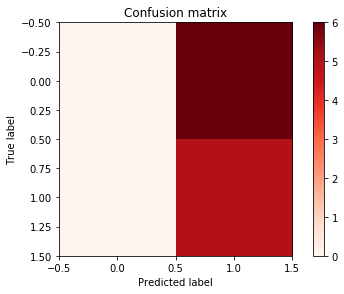

In [7]:
log_clf=LogisticRegression()
train_score(log_clf,X,y)

## ROC Curve

Text(0,0.5,'TPR')

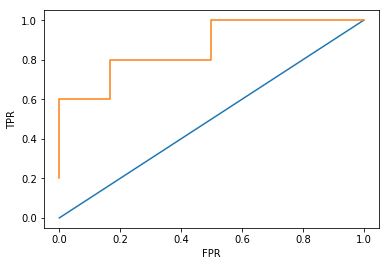

In [8]:
log = LogisticRegression()
log.fit(xtrain,np.ravel(ytrain))
y_score=log.predict_proba(xtest)[:,1]

fpr, tpr,thres = roc_curve(ytest, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
# Plotting our Baseline..
plt.plot([0,1],[0,1])
plt.plot(fpr,tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')

In [9]:
tpr

array([0.2, 0.6, 0.6, 0.8, 0.8, 1. , 1. ])

In [10]:
thres

array([0.65956375, 0.60232587, 0.57890769, 0.56271056, 0.55020785,
       0.54734702, 0.5005835 ])

In [11]:
1-thres

array([0.34043625, 0.39767413, 0.42109231, 0.43728944, 0.44979215,
       0.45265298, 0.4994165 ])

In [12]:
df.head()

,artist,platinum,followers,popularity
36,Drake,1,19729716,99
640,Nicki Minaj,1,10431818,91
110,Kendrick Lamar,1,8813295,94
95,Kanye West,1,7259123,90
861,Wiz Khalifa,0,6767452,86


# Gradient Descent

## Does GD implement theta, l1,l2, and combo?

# SVM

In [13]:
# fit linear model
model_svm = svm.SVC(kernel='linear')
ytrain3 = np.ravel(ytrain)
model_svm.fit(xtrain, ytrain3)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [14]:
# predict out of sample
y_pred = model_svm.predict(xtest)
# check accuracy
accuracy_score(ytest,y_pred)

0.7272727272727273

In [15]:
confusion_matrix(ytest,y_pred)

array([[5, 1],
       [2, 3]])

In [16]:
model_svm2 = svm.SVC(kernel='rbf', gamma = 0.001)
model_svm2.fit(xtrain, ytrain3)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [17]:
y_pred2 = model_svm2.predict(xtest)
y_pred2

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [18]:
accuracy_score(ytest,y_pred2)

0.5454545454545454

In [19]:
confusion_matrix(ytest,y_pred2)

array([[6, 0],
       [5, 0]])

## SVC

In [38]:
y,X=dmatrices('platinum ~ followers + popularity',data=df,return_type='dataframe')

In [39]:
def quick_test(model, X, y):
    xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2)
    model.fit(xtrain, ytrain)
    return model.score(xtest, ytest)

def quick_test_afew_times(model, X, y, n=10):
    return np.mean([quick_test(model, X, y) for j in range(n)])

In [40]:
linearsvc = LinearSVC()
quick_test_afew_times(linearsvc, X, y)

/Users/cyrusrustomji/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.4999999999999999

# Decision Trees

In [44]:
y,X=dmatrices('platinum ~ followers + popularity',data=df,return_type='dataframe')
xtrain, xtest, ytrain, ytest = cross_validation.train_test_split(X, y, test_size=0.2, random_state=1234)

In [110]:
for i in range(1,20,1):
    decisiontree = DecisionTreeClassifier(max_depth=i)
    print(i,quick_test_afew_times(decisiontree, X, y))

1 0.7727272727272727
2 0.8454545454545455
3 0.8727272727272727
4 0.8181818181818181
5 0.8272727272727274
6 0.8636363636363636
7 0.809090909090909
8 0.7818181818181819
9 0.7909090909090909
10 0.8181818181818181
11 0.7818181818181819
12 0.8454545454545453
13 0.7909090909090909
14 0.8363636363636363
15 0.8545454545454545
16 0.7454545454545455
17 0.8272727272727272
18 0.809090909090909
19 0.8636363636363636


In [112]:
for i in range(1,10,1):
    randomforest = RandomForestClassifier(n_estimators=i)
    yrf = np.ravel(y)
    print(i, quick_test_afew_times(randomforest, X, yrf))

1 0.8272727272727274
2 0.8454545454545455
3 0.7818181818181819
4 0.7818181818181819
5 0.8636363636363635
6 0.8636363636363636
7 0.7818181818181819
8 0.8272727272727272
9 0.8090909090909092


In [66]:
decisiontree = DecisionTreeClassifier()
quick_test_afew_times(decisiontree, X, y)

0.8363636363636363

In [115]:
linearsvc = LinearSVC(loss='hinge')
quick_test_afew_times(linearsvc, X, yrf)

0.36363636363636365

In [68]:
svc = SVC()
quick_test_afew_times(svc, X, yrf)

0.6363636363636365

In [69]:
s2 = SVC()
X2 = (0.5-X) * 2
quick_test_afew_times(s2, X2, yrf)

0.5999999999999999